# 📊 Customer Churn Prediction

This notebook predicts whether a customer will churn (leave the telecom company) or not using machine learning models.  
We will perform data preprocessing, exploratory data analysis (EDA), feature engineering, model training, evaluation, and explainability using SHAP.  

## 🔹 Import Libraries
We start by importing all the necessary libraries for data handling, visualization, preprocessing, and machine learning.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

## 🔹 Load Dataset
We load the **Telco Customer Churn dataset** and check its basic structure, info, shape, and missing values.


In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

## Initial Exploration

- Check dataset structure and data types  
- Shape of the dataset (rows, columns)  
- Inspect target variable distribution (`Churn`)  


In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print(df.info())
print(df.shape)
print(df['Churn'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## 🔹 Handle Missing Values
The column `TotalCharges` contains missing values and non-numeric entries.  
We convert it to numeric and impute missing values with the median.


In [6]:
df.isnull().sum()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
print("\nMissing values in Total Charges:", df['TotalCharges'].isnull().sum())
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace = True)


Missing values in Total Charges: 11


## 🔹 Churn Distribution
We check how many customers churned vs stayed and visualize it.


Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


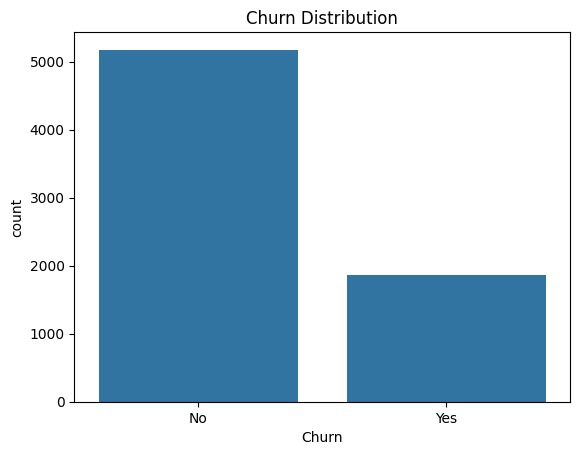

In [7]:
print(df['Churn'].value_counts())
print(df['Churn'].value_counts(normalize = True)*100)

sns.countplot(x = 'Churn', data = df)
plt.title('Churn Distribution')
plt.show()

## 🔹 Numerical Feature Analysis
We analyze numerical features (`tenure`, `MonthlyCharges`, `TotalCharges`) using histograms and boxplots to see their distribution and relationship with churn.


            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2281.916928
std      24.559481       30.090047   2265.270398
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    402.225000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


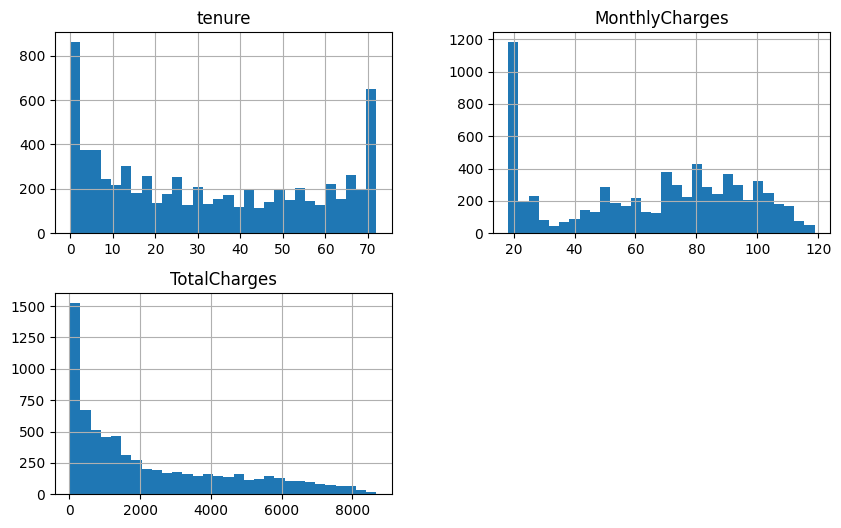

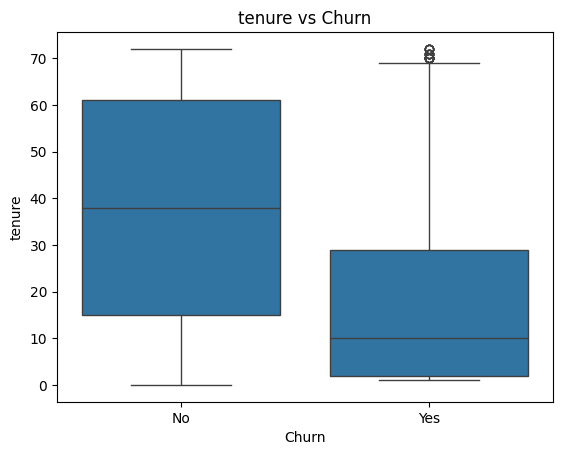

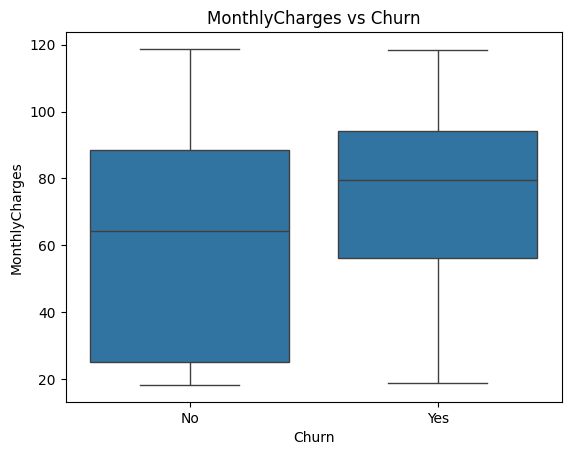

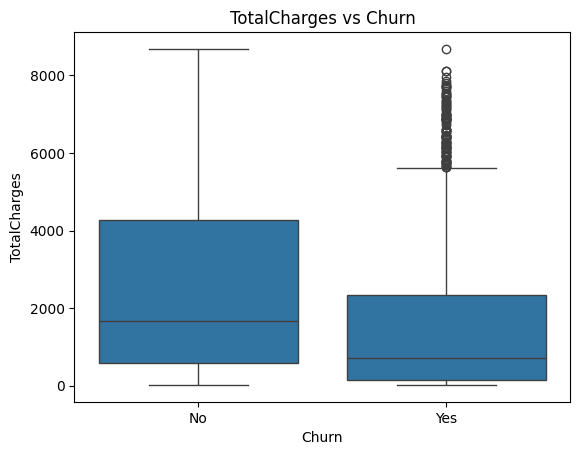

In [8]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

print(df[num_cols].describe())
df[num_cols].hist(bins = 30, figsize = (10,6))
plt.show()

for col in num_cols:
    sns.boxplot(x = 'Churn', y = col, data = df)
    plt.title(f"{col} vs Churn")
    plt.show()

## 🔹 Categorical Feature Analysis
We analyze categorical features (e.g., gender, InternetService, Contract) using count plots to observe their relation with churn.


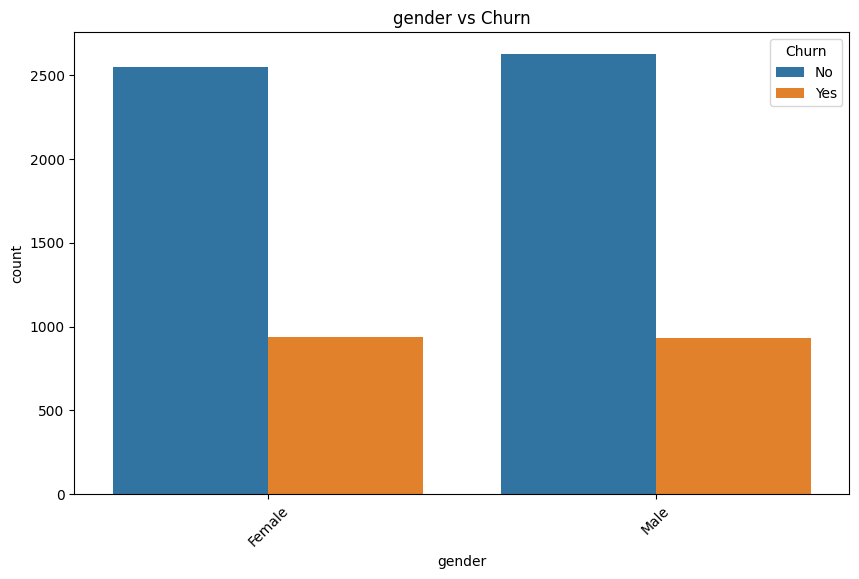

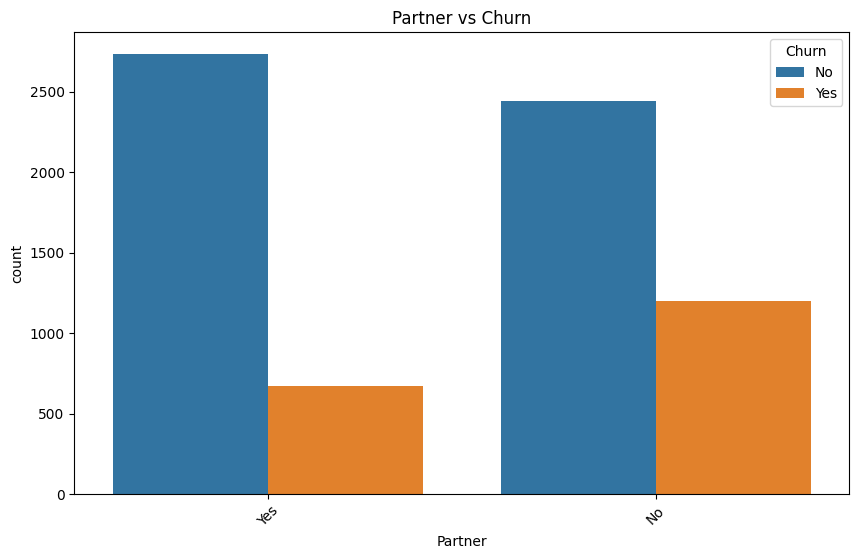

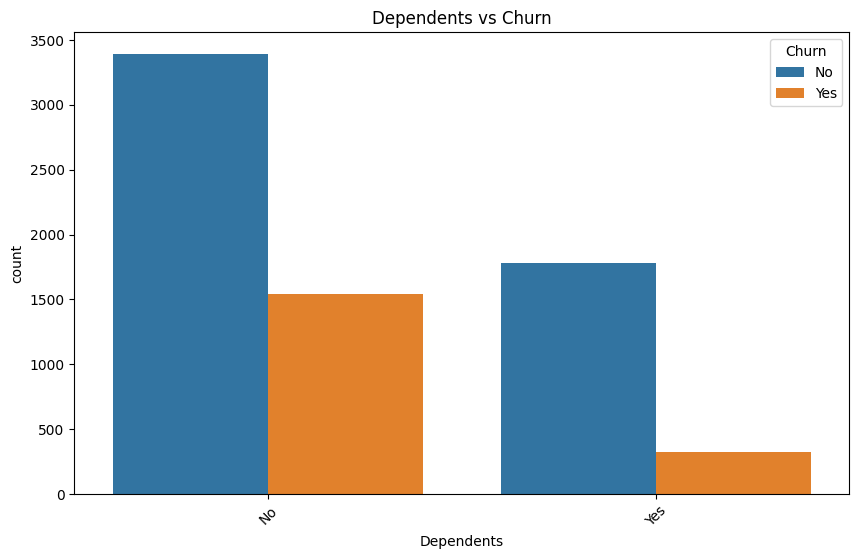

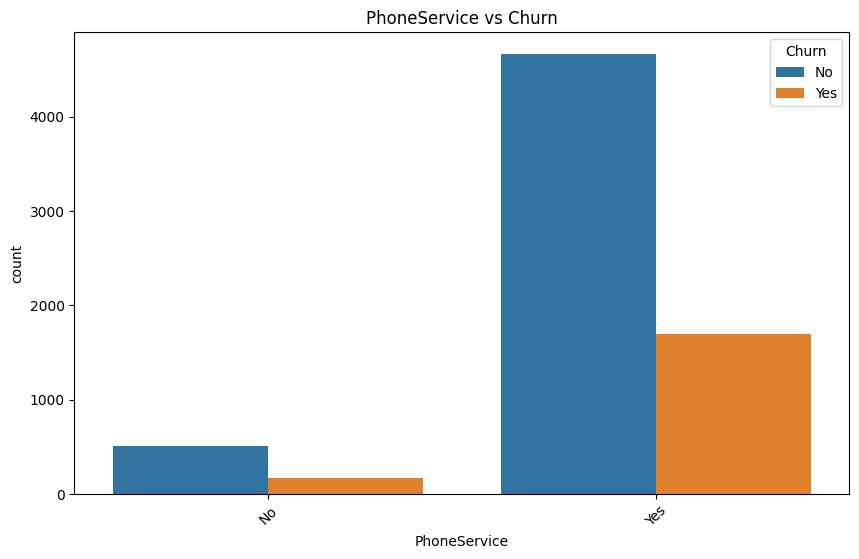

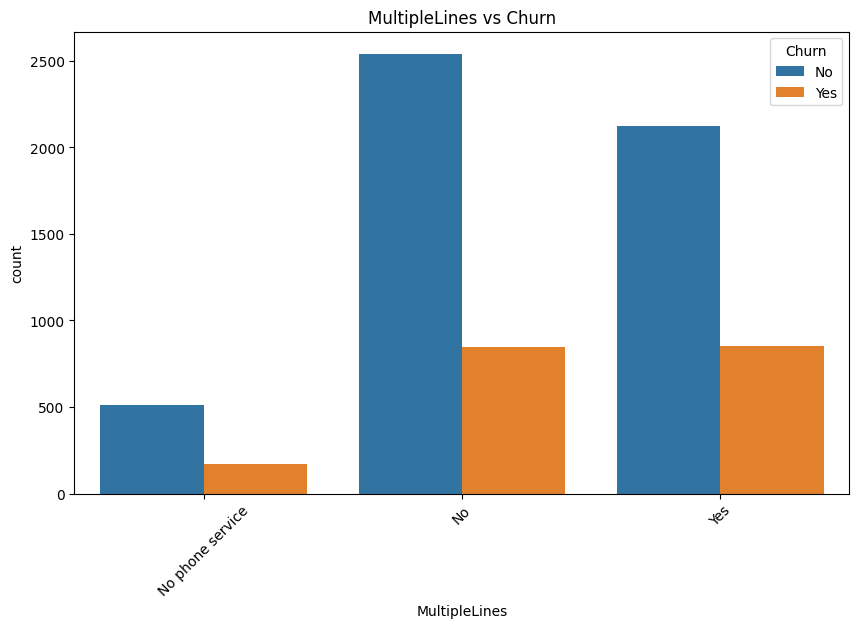

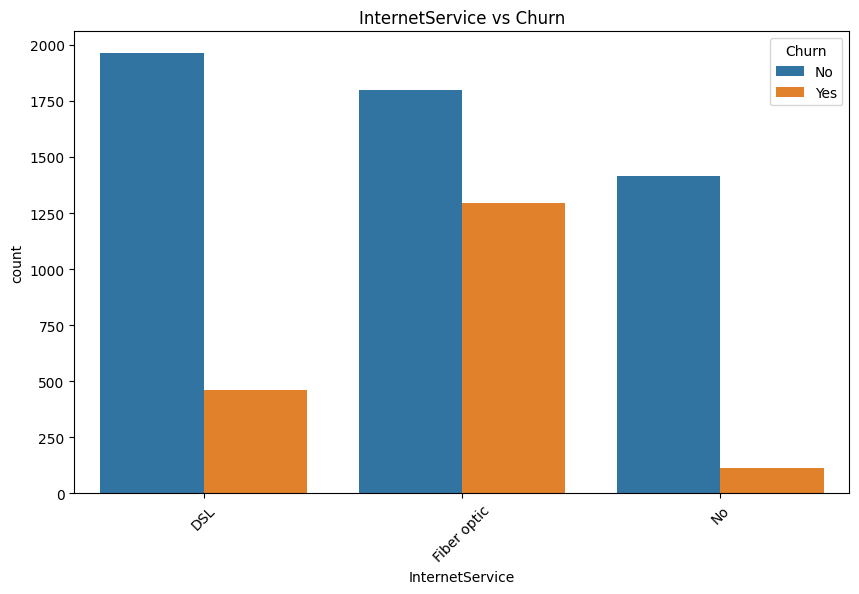

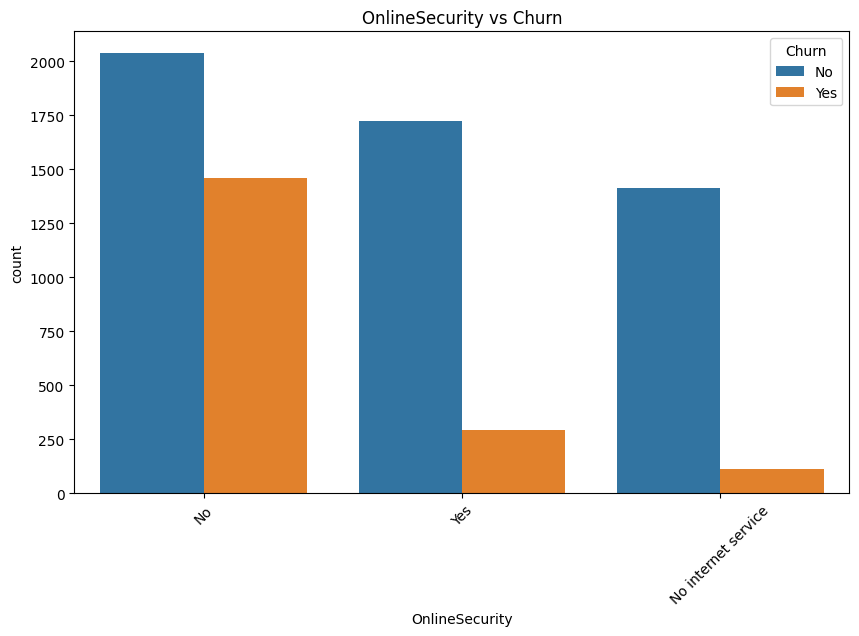

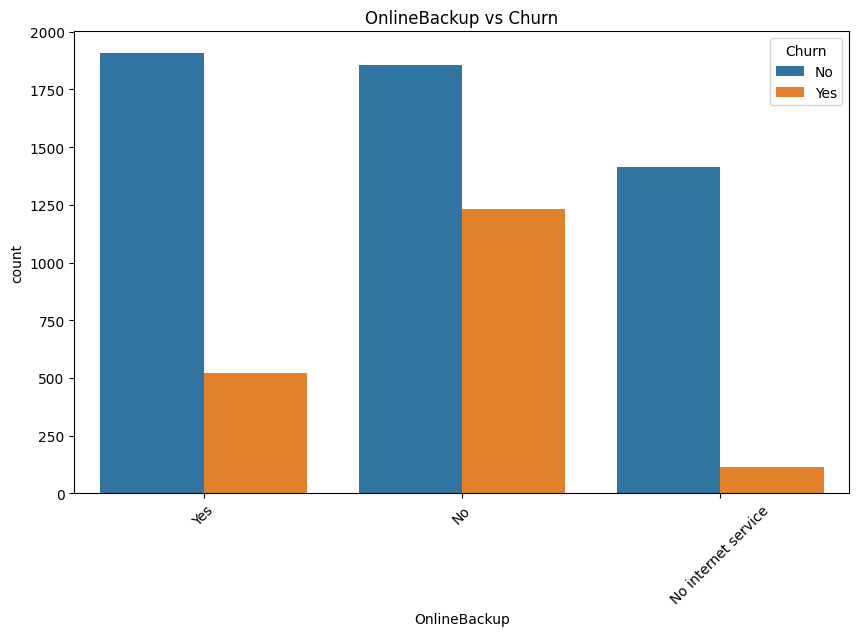

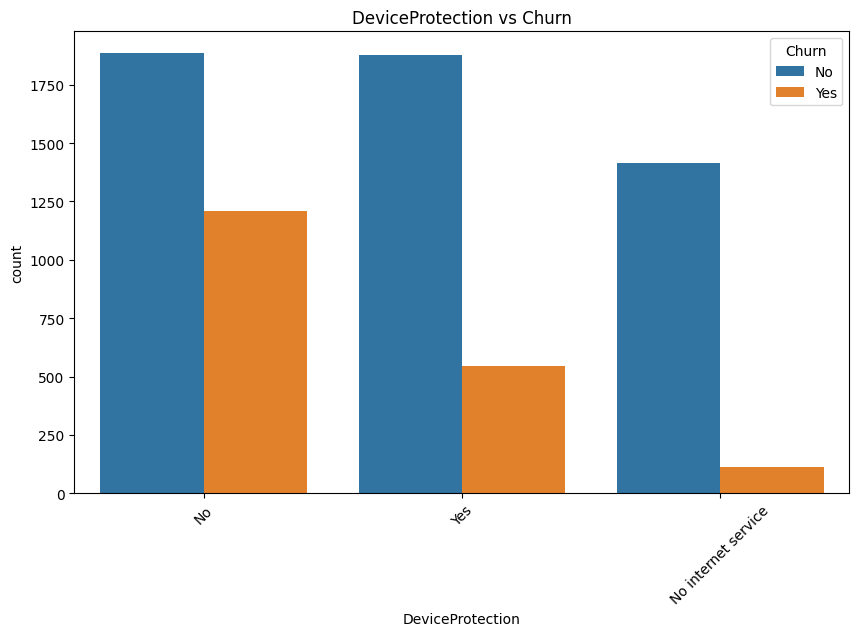

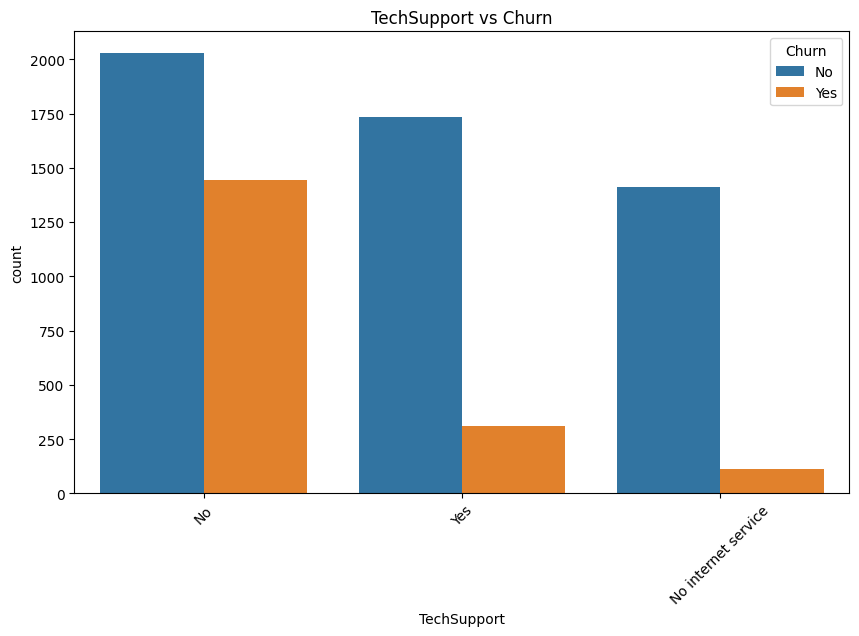

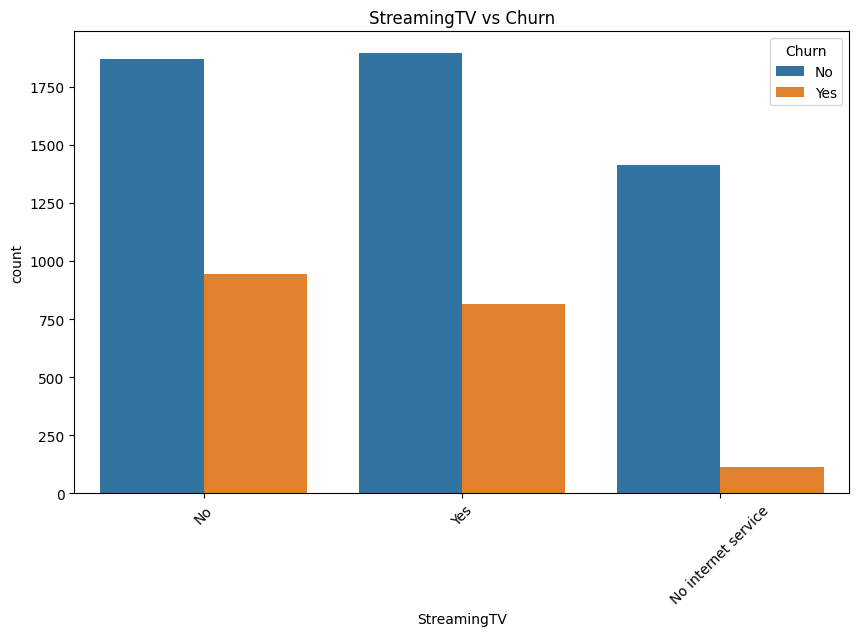

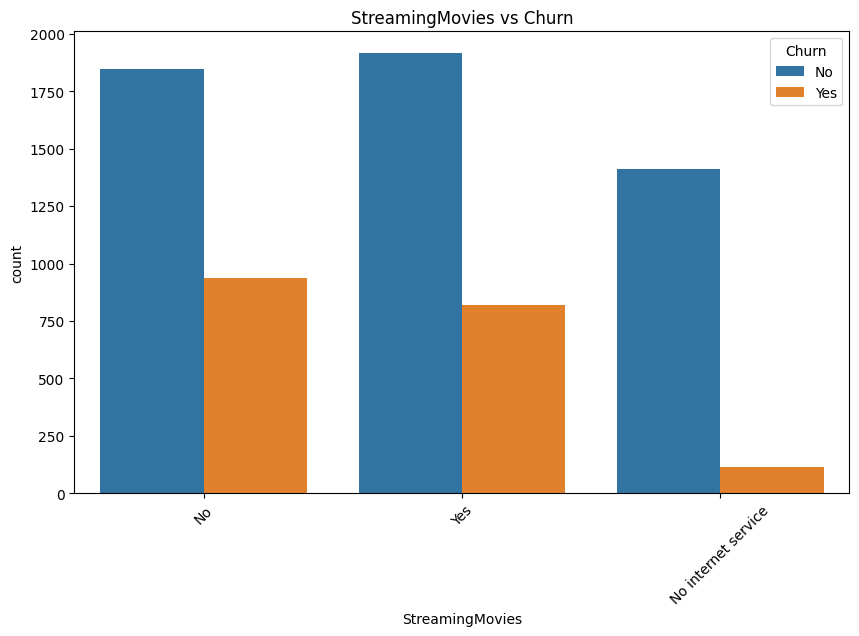

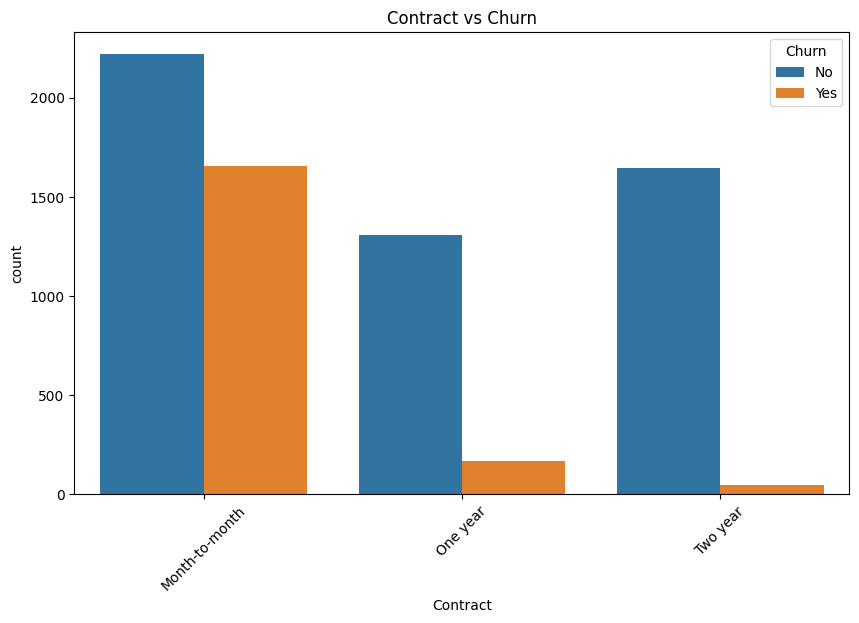

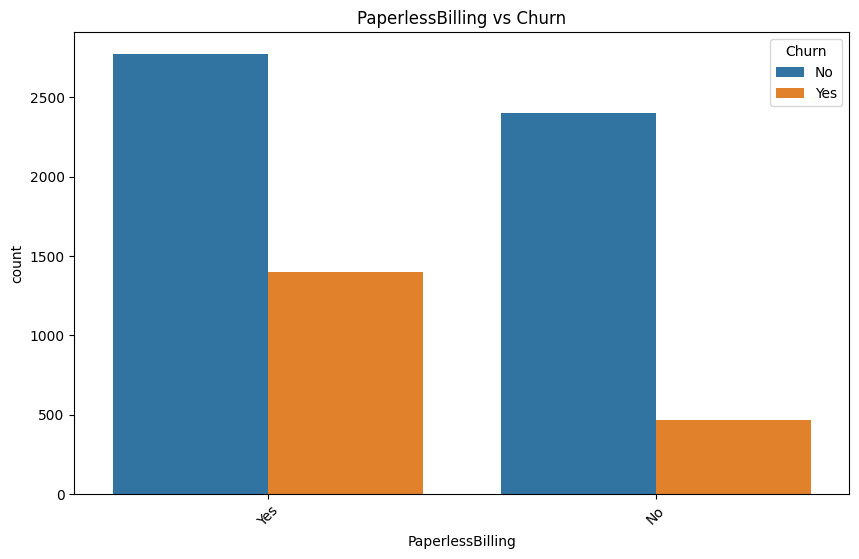

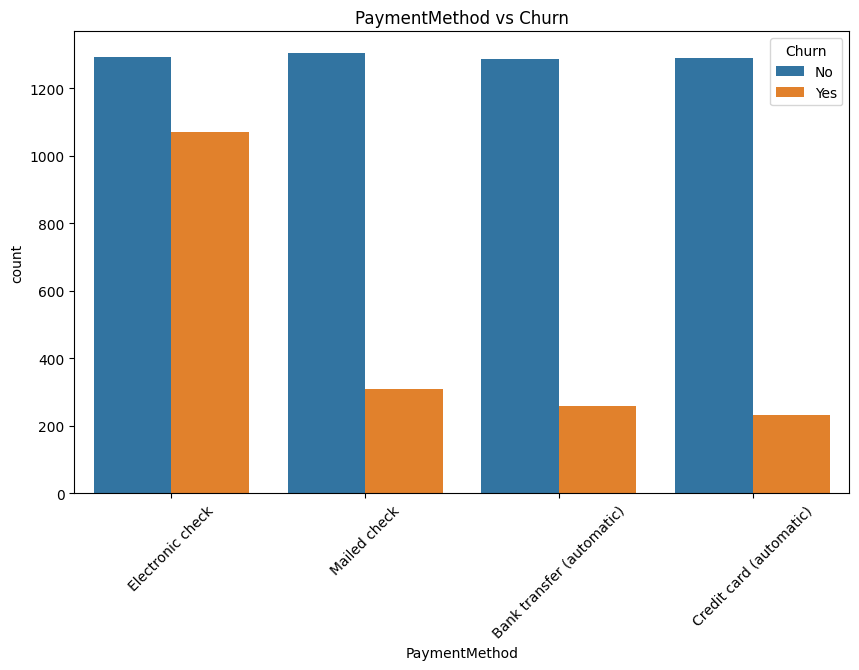

In [9]:
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c not in ['customerID', 'Churn']]

for col in cat_cols:
    plt.figure(figsize = (10,6))
    sns.countplot(x = col, hue = 'Churn', data = df)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation = 45)
    plt.show()

## 🔹 Correlation Analysis
We compute the correlation matrix for numerical features to check multicollinearity and relationship with churn.


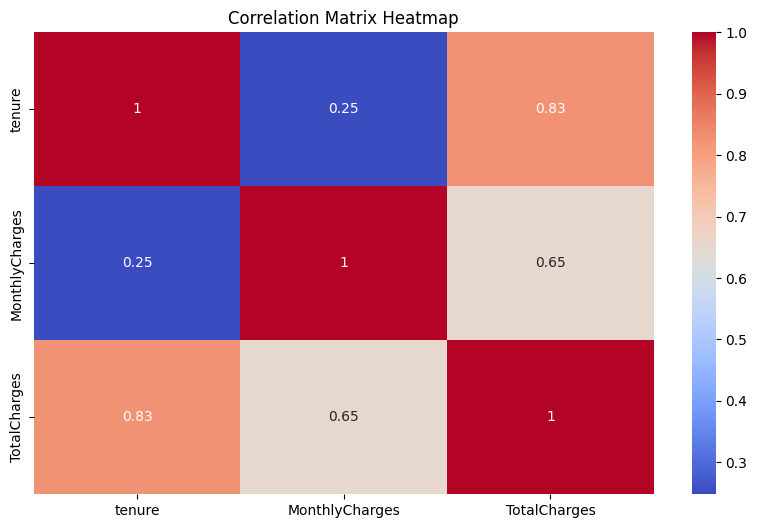

In [10]:
corr = df[num_cols].corr()
plt.figure(figsize = (10,6))
sns.heatmap(corr, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

## 🔹 Data Preprocessing
- Drop irrelevant columns (`customerID`)  
- Encode target variable (`Churn`) as 0/1  
- Apply **One-Hot Encoding** to categorical variables  
- Split the dataset into train/test sets


In [11]:
df = df.drop('customerID', axis = 1)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

df_encoded = pd.get_dummies(df, drop_first=True)

x = df_encoded.drop('Churn', axis = 1)
y = df_encoded['Churn']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

print("Train Shape:", x_train.shape)
print("Test Shape:", x_test.shape)

Train Shape: (5634, 30)
Test Shape: (1409, 30)


## 🔹 Feature Engineering
We create additional features:  
- **AvgMonthlyCharges** = TotalCharges / (tenure + 1)  
- **TenureGroup** = Bucket customers based on tenure (`New`, `Established`, `loyal`)  
- **StreamingServices** = Combine `StreamingTV` and `StreamingMovies` into one feature  


In [12]:
df['AvgMonthlyCharges'] = df['TotalCharges'] / (df['tenure'] + 1)

In [13]:
def tenure_buckets(tenure):
    if tenure <= 12:
        return "New"
    if tenure <= 24:
        return "Established"
    if tenure <= 48:
        return "loyal"
    
df['TenureGroup'] = df['tenure'].apply(tenure_buckets)

In [14]:
def streaming_services(row):
    if (row['StreamingTV'] == 'Yes') or (row['StreamingMovies'] == 'Yes'):
        return 'Yes'
    else:
        return 'No'
    
df['StreamingServices'] = df.apply(streaming_services, axis = 1)

## 🔹 EDA on New Features
We visualize churn patterns across `TenureGroup`, `StreamingServices`, and `AvgMonthlyCharges`.


In [15]:
df = df.drop(['StreamingTV', 'StreamingMovies'], axis = 1)
df_encoded = pd.get_dummies(df, drop_first = True)

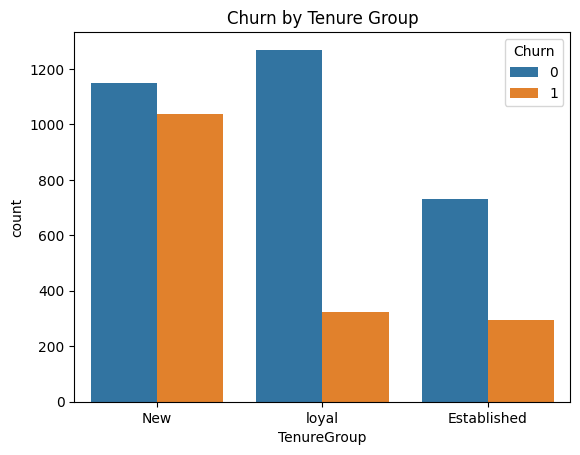

In [16]:
sns.countplot(x = 'TenureGroup', hue = 'Churn', data = df)
plt.title('Churn by Tenure Group')
plt.show()

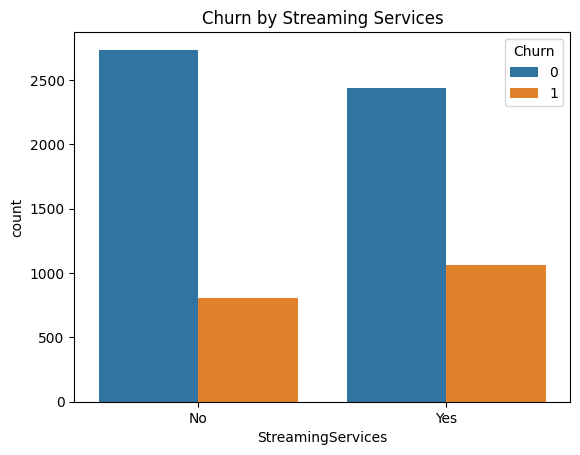

In [17]:
sns.countplot(x = 'StreamingServices', hue = 'Churn', data = df)
plt.title('Churn by Streaming Services')
plt.show()

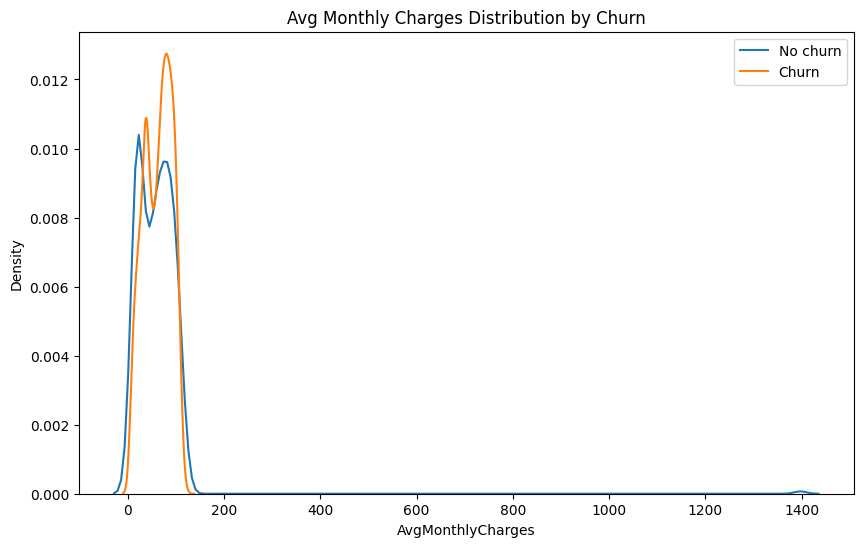

In [18]:
plt.figure(figsize = (10,6))
sns.kdeplot(df[df['Churn'] == 0]['AvgMonthlyCharges'], label = 'No churn')
sns.kdeplot(df[df['Churn'] == 1]['AvgMonthlyCharges'], label = 'Churn')
plt.title('Avg Monthly Charges Distribution by Churn')
plt.legend()
plt.show()

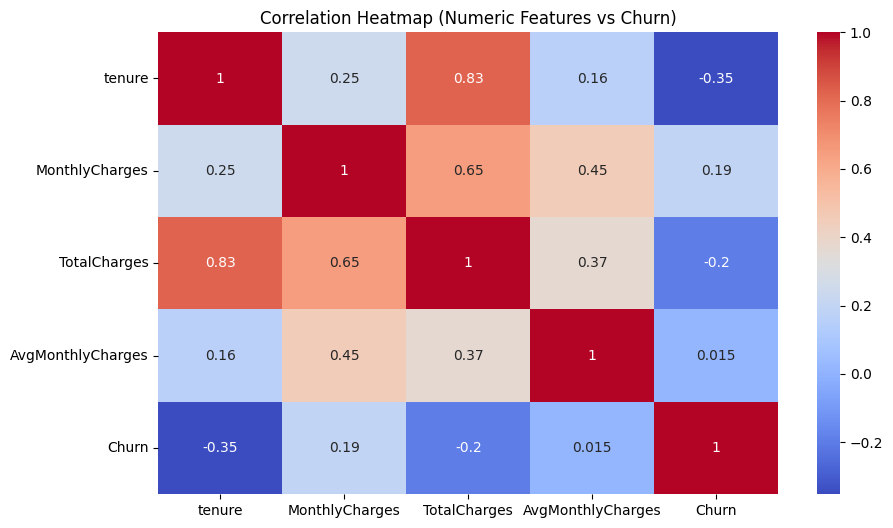

In [19]:
num_corr = df[['tenure','MonthlyCharges','TotalCharges','AvgMonthlyCharges','Churn']].corr()

plt.figure(figsize = (10,6))
sns.heatmap(num_corr, annot = True, cmap = 'coolwarm')
plt.title('Correlation Heatmap (Numeric Features vs Churn)')
plt.show()

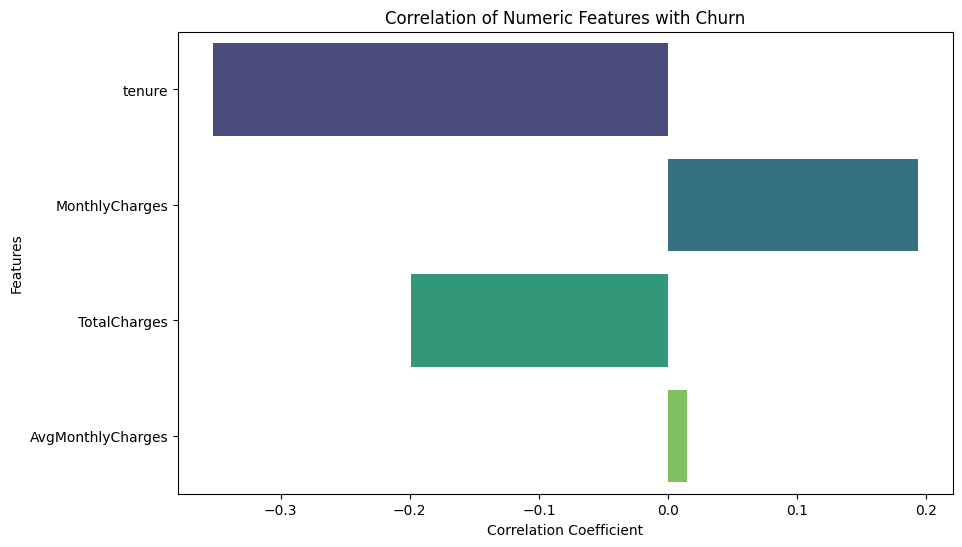

In [20]:
corr = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharges', 'Churn']].corr()['Churn'].drop('Churn')

plt.figure(figsize = (10,6))
sns.barplot(x = corr.values, y = corr.index, palette = 'viridis')
plt.title('Correlation of Numeric Features with Churn')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

## 🔹 Logistic Regression
We train a Logistic Regression model and evaluate it using:  
- Classification report  
- Confusion matrix  
- ROC curve  


In [21]:
log = LogisticRegression(max_iter = 1000, class_weight = 'balanced', solver = 'liblinear')
log.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

Roc-Auc Score: 0.8423493244465112


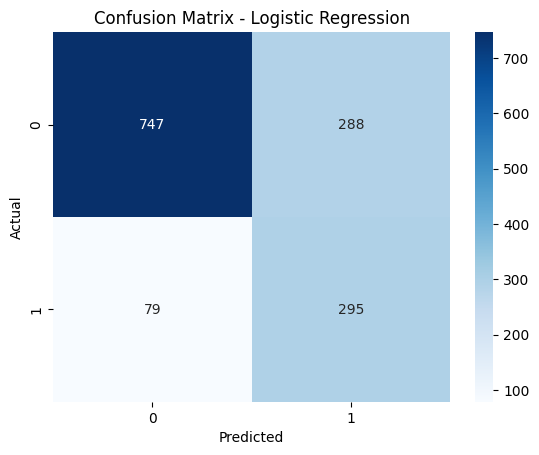

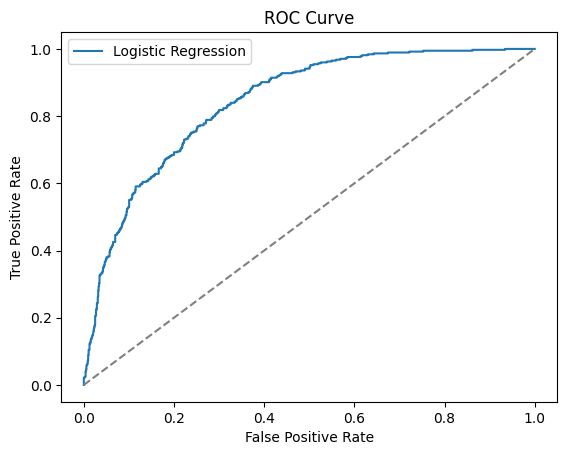

In [24]:
y_pred = log.predict(x_test)
y_proba = log.predict_proba(x_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Roc-Auc Score:", roc_auc_score(y_test, y_proba))

sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr,  label = 'Logistic Regression')
plt.plot([0,1], [0,1], '--', color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 🔹 Random Forest Classifier
We train a Random Forest model and evaluate it similarly using confusion matrix and ROC curve.


In [25]:
reg = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state = 42)
reg.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

Classificatio Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC-AUC Score: 0.8245705133173165


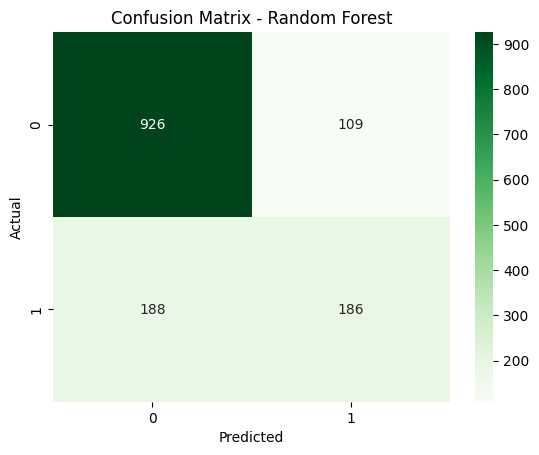

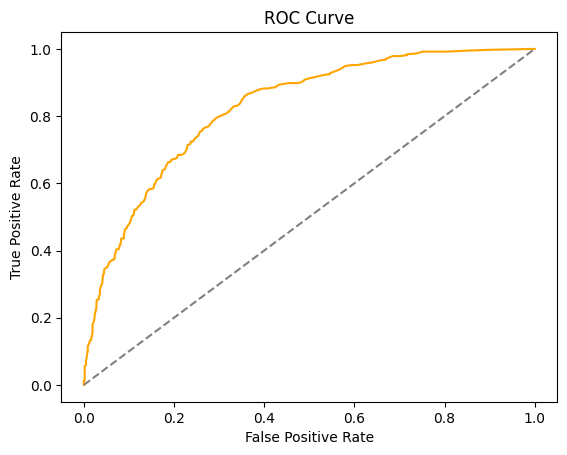

In [26]:
y_pred_rf = reg.predict(x_test)
y_proba_rf = reg.predict_proba(x_test)[:,1]

print("Classificatio Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot = True, fmt = 'd', cmap = 'Greens')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest', color  = 'orange')
plt.plot([0,1],[0,1],'--', color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


## 🔹 XGBoost Classifier
We train an XGBoost model with class balancing (`scale_pos_weight`) and evaluate it.


In [27]:
xgb = XGBClassifier(eval_metric = 'logloss', random_state = 42, scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum())
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.70      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409

ROC-AUCScore: 0.8315675940995633


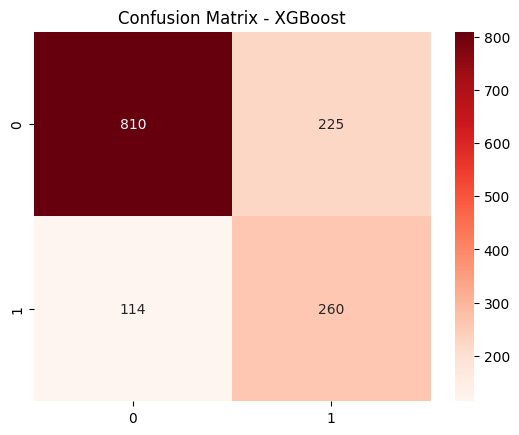

In [28]:
x_pred = xgb.predict(x_test)
x_proba = xgb.predict_proba(x_test)[:,1]

print("Classification Report:\n", classification_report(y_test, x_pred))
print("ROC-AUCScore:", roc_auc_score(y_test, x_proba))

sns.heatmap(confusion_matrix(y_test, x_pred), annot = True, fmt = 'd', cmap = 'Reds')
plt.title('Confusion Matrix - XGBoost')
plt.show()

## 🔹 LightGBM Classifier
We train a LightGBM model and evaluate it.  


In [29]:
lgb = LGBMClassifier(class_weight = 'balanced', random_state = 42)
lgb.fit(x_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.75      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409

ROC-AUC Score: 0.8329342013485237


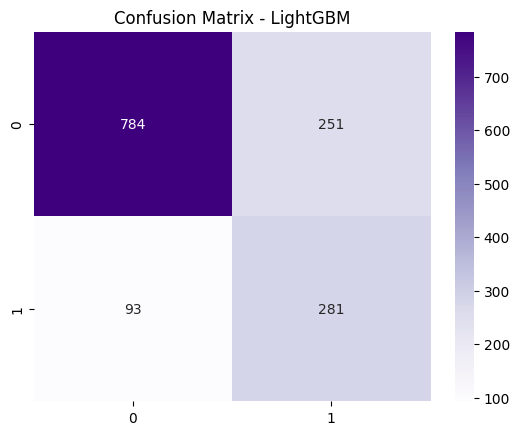

In [30]:
lg_pred = lgb.predict(x_test)
lg_proba = lgb.predict_proba(x_test)[:,1]

print("Classification Report:\n", classification_report(y_test, lg_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, lg_proba))

sns.heatmap(confusion_matrix(y_test, lg_pred),annot = True, fmt = 'd', cmap = 'Purples')
plt.title('Confusion Matrix - LightGBM')
plt.show()

## 🔹 Model Comparison
We compare **Logistic Regression, Random Forest, XGBoost, and LightGBM** based on:  
- Precision  
- Recall  
- F1-score  
- ROC-AUC  

A bar chart summarizes the performance of all models.



Classification Report for LogisticRegression
              precision    recall  f1-score   support

    No Churn       0.90      0.72      0.80      1035
       Churn       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



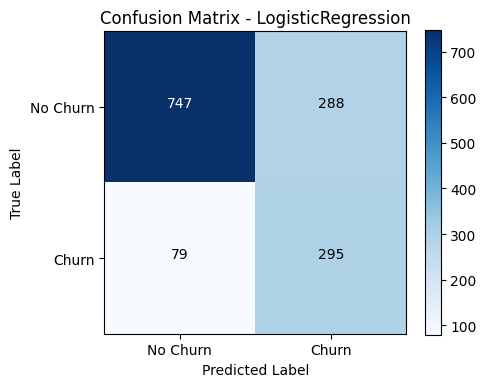


Classification Report for RandomForest
              precision    recall  f1-score   support

    No Churn       0.83      0.89      0.86      1035
       Churn       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



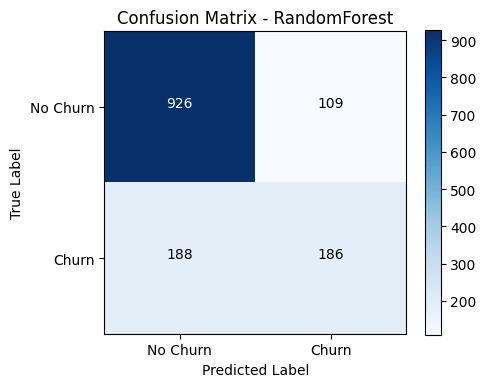


Classification Report for XGBoost
              precision    recall  f1-score   support

    No Churn       0.88      0.78      0.83      1035
       Churn       0.54      0.70      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409



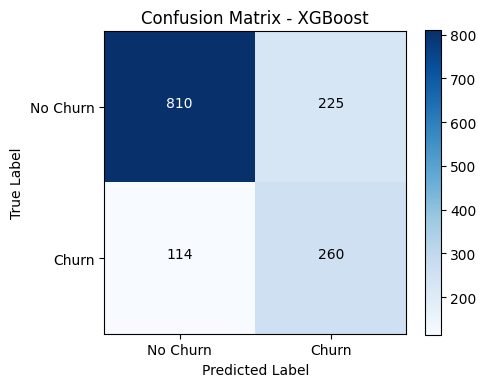

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Classification Report for LightGBM
              precision    recall  f1-score   support

    No Churn       0.89      0.76      0.82      1035
       Churn       0.53      0.75      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409



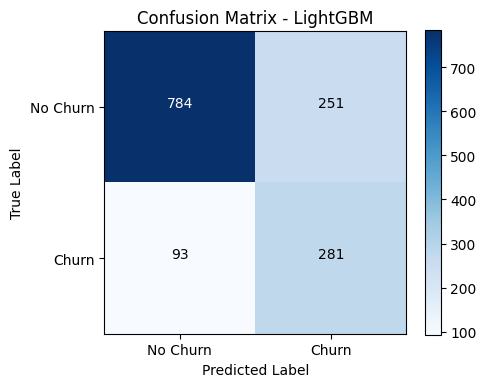


Model Comparison Table:

                Model  Precision    Recall  F-1 Score  Roc-Auc Score
0  LogisticRegression   0.506003  0.788770   0.616510       0.842349
1        RandomForest   0.630508  0.497326   0.556054       0.824571
2             XGBoost   0.536082  0.695187   0.605355       0.831568
3            LightGBM   0.528195  0.751337   0.620309       0.832934


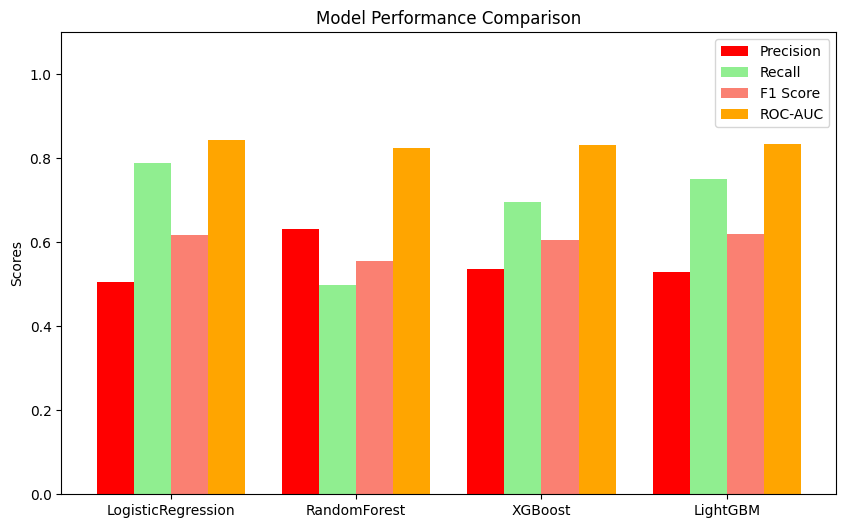

In [31]:
# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter = 1000, class_weight = 'balanced', solver = 'liblinear'),
    "RandomForest": RandomForestClassifier(n_estimators = 200, class_weight = 'balanced', random_state = 42),
    "XGBoost": XGBClassifier(eval_metric = 'logloss', random_state = 42, scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()),
    "LightGBM": LGBMClassifier(class_weight = 'balanced', random_state=42)
}

results = []

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Churn', 'Churn'])
    plt.yticks(tick_marks, ['No Churn', 'Churn'])

    # Numbers inside cells
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Train and evaluate
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:,1]

    # Metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    results.append([name, precision, recall, f1, roc_auc])

    # Print classification report
    print(f"\nClassification Report for {name}")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, name)

# Results DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Precision", "Recall", "F-1 Score", "Roc-Auc Score"])
print("\nModel Comparison Table:\n")
print(results_df)

# Bar chart
x = np.arange(len(results_df['Model']))
width = 0.2

plt.figure(figsize=(10,6))
plt.bar(x - 1.5*width, results_df['Precision'], width, label='Precision', color='red')
plt.bar(x - 0.5*width, results_df['Recall'], width, label='Recall', color='lightgreen')
plt.bar(x + 0.5*width, results_df['F-1 Score'], width, label='F1 Score', color='salmon')
plt.bar(x + 1.5*width, results_df['Roc-Auc Score'], width, label='ROC-AUC', color='orange')

plt.xticks(x, results_df['Model'])
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.1)
plt.legend()
plt.show()

## 🔹 Model Explainability with SHAP
We use **SHAP values** to interpret feature importance and visualize:  
- SHAP summary plot (dot & bar plots)  
- SHAP force plot for an individual customer prediction


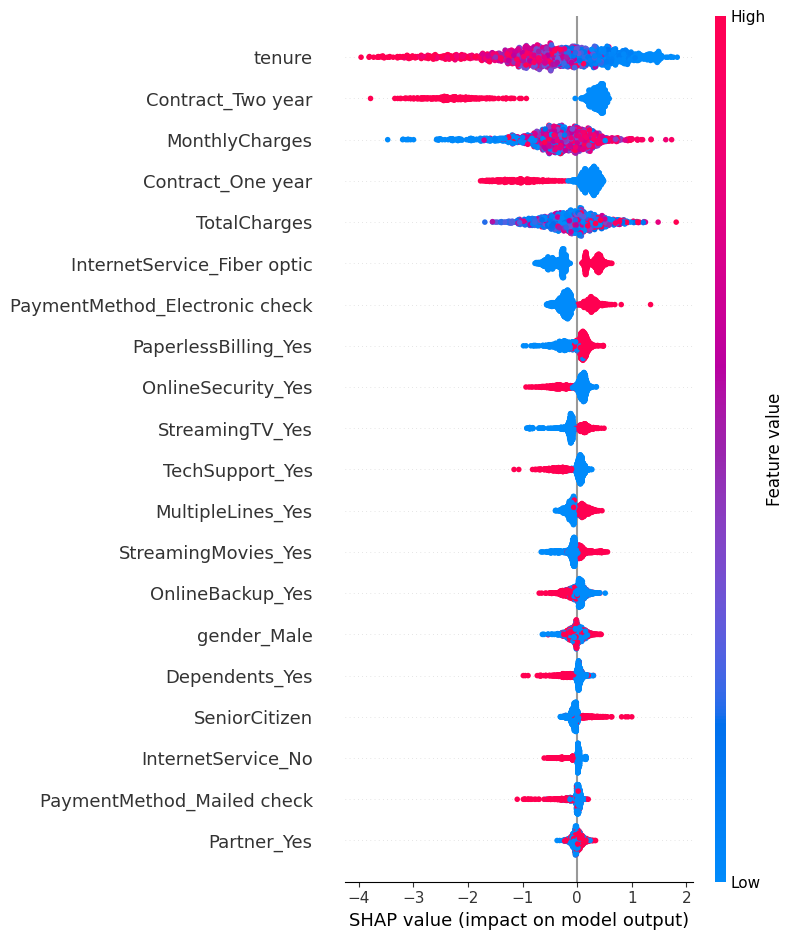

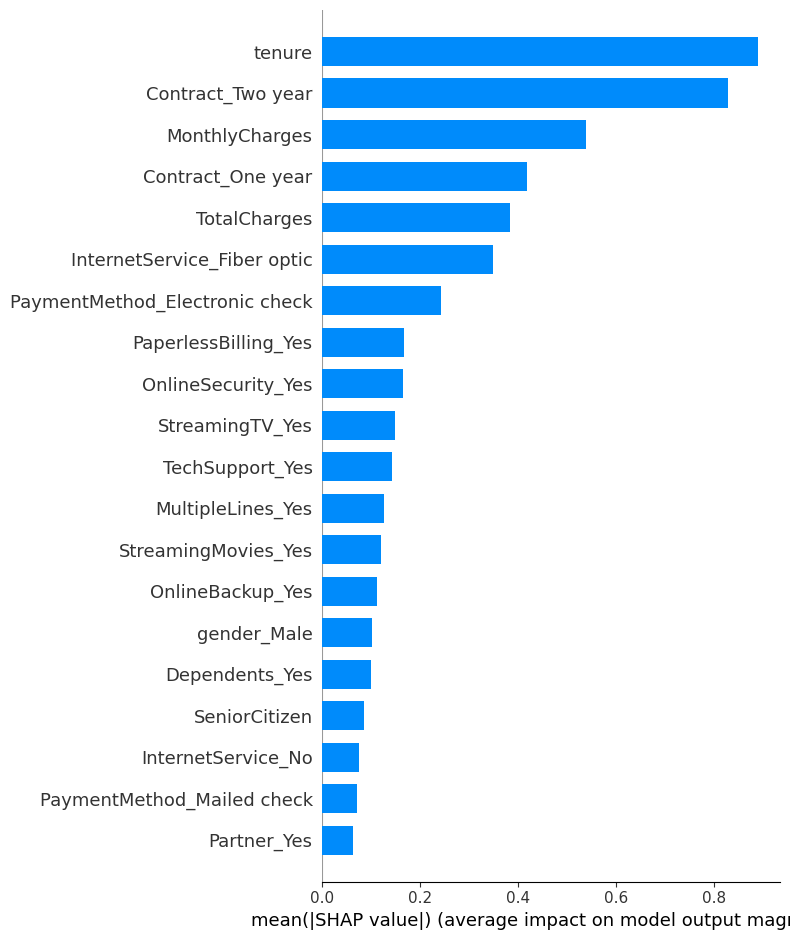

In [32]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer(x_test)

shap.summary_plot(shap_values, x_test)

shap.summary_plot(shap_values, x_test, plot_type = 'bar')

In [33]:
shap_values = explainer(x_test)
customer_index = 0

shap.initjs()
shap.force_plot(shap_values[customer_index])

# ✅ Conclusion
- Multiple models were trained and compared.  
- **XGBoost and LightGBM performed the best** in terms of ROC-AUC and F1-score.  
- SHAP helped explain which features drive churn predictions.  
